# Notes
This jupyter notebook is the starter code jon provided plus my own code and edits. It also uses code from the signal processing notebook he provided.

## Dynamic Time Warping
If you choose to explore Dynamic Time Warping (DTW), I recommend fastdtw. You can install this by typing the following in cell:
```
import sys
!{sys.executable} -m pip install fastdtw
```
See https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/ for more details

In [1]:
import sys
!{sys.executable} -m pip install fastdtw

  Running setup.py bdist_wheel for fastdtw: started
  Running setup.py bdist_wheel for fastdtw: finished with status 'done'
  Stored in directory: C:\Users\nicol\AppData\Local\pip\Cache\wheels\61\62\46\5a9cc316aa50cc4fb36fd4bf14e7dd206642db3247d7746c23
Successfully built fastdtw


In [2]:
# This cell includes the major classes used in our classification analyses
import matplotlib.pyplot as plt # needed for plotting
import numpy as np # numpy is primary library for numeric array (and matrix) handling
from scipy import signal 

# Each accelerometer and gyroscope log file gets parsed and made into a SensorData object
class SensorData:
    
    # Constructors in Python look like this (strangely enough)
    # All arguments are numpy arrays except sensorType, which is a str
    def __init__(self, sensorType, currentTimeMs, sensorTimestampMs, x, y, z):
        self.sensorType = sensorType
        
        # On my mac, I could cast as straight-up int but on Windows, this failed
        # This is because on Windows, a long is 32 bit but on Unix, a long is 64bit
        # So, forcing to int64 to be safe. See: https://stackoverflow.com/q/38314118
        self.currentTimeMs = currentTimeMs.astype(np.int64)
        self.sensorTimestampMs = sensorTimestampMs.astype(np.int64)
        
        self.x = x.astype(float)
        self.y = y.astype(float)
        self.z = z.astype(float)
   
        # calculate the magnitude of the signal
        self.mag = np.sqrt(self.x**2 + self.y**2 + self.z**2)
        
        self.sampleLengthInSecs = (self.currentTimeMs[-1] - self.currentTimeMs[0]) / 1000.0
        self.samplesPerSecond = len(self.currentTimeMs) / self.sampleLengthInSecs 
        
    # Returns a dict of numpy arrays
    def get_data(self):
        return {"x":self.x, "y":self.y, "z":self.z, "mag":self.mag}
    
    # Creates a new padded version of each data array with zeroes. Throws exception
    # if newArrayLength smaller than the current data array (and thus nothing to pad)
    # See: https://docs.scipy.org/doc/numpy-1.14.1/reference/generated/numpy.pad.html
    def pad_with_zeros(self, newArrayLength):
        self.signalLengthBeforePadding = len(self.x)
        arrayLengthDiff = newArrayLength - len(self.x)
        if arrayLengthDiff < 0:
            raise ValueError("New array length '{}' must be larger than current array length '{}".
                             format(newArrayLength, len(self.x)))
        
        # np.pad allows us to pad either the left side, right side, or both sides of an array
        # in this case, we are padding only the right side. 
        # See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
        self.x_padded = np.pad(self.x, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.y_padded = np.pad(self.y, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.z_padded = np.pad(self.z, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.mag_padded = np.pad(self.mag, (0, arrayLengthDiff), 'constant', constant_values=0)
        
    # Creates a new padded version of each data array with the mean of that array. Throws exception
    # if newArrayLength smaller than the current data array (and thus nothing to pad)
    # See: https://docs.scipy.org/doc/numpy-1.14.1/reference/generated/numpy.pad.html
    def pad_with_mean(self, newArrayLength):
        self.signalLengthBeforePadding = len(self.x)
        arrayLengthDiff = newArrayLength - len(self.x)
        if arrayLengthDiff < 0:
            raise ValueError("New array length '{}' must be larger than current array length '{}".
                             format(newArrayLength, len(self.x)))
        
        # np.pad allows us to pad either the left side, right side, or both sides of an array
        # in this case, we are padding only the right side. 
        # See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
        self.x_padded = np.pad(self.x, (0, arrayLengthDiff), 'mean')
        self.y_padded = np.pad(self.y, (0, arrayLengthDiff), 'mean')
        self.z_padded = np.pad(self.z, (0, arrayLengthDiff), 'mean')
        self.mag_padded = np.pad(self.mag, (0, arrayLengthDiff), 'mean')

# A trial is one gesture recording and includes an accel SensorData object
# In the future, this could be expanded to include other recorded sensors (e.g., a gyro)
# that may be recorded simultaneously
class Trial:
    
    # We actually parse the sensor log files in the constructor--this is probably bad practice
    # But offers a relatively clean solution
    def __init__(self, gestureName, endTimeMs, trialNum, accelLogFilenameWithPath):
        self.gestureName = gestureName
        self.trialNum = trialNum
        self.endTimeMs = endTimeMs
        self.accelLogFilenameWithPath = accelLogFilenameWithPath
        self.accelLogFilename = os.path.basename(accelLogFilenameWithPath)
        
        # unpack=True puts each column in its own array, see https://stackoverflow.com/a/20245874
        # I had to force all types to strings because auto-type inferencing failed
        parsedAccelLogData = np.genfromtxt(accelLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        # The asterisk is really cool in Python. It allows us to "unpack" this variable
        # into arguments needed for the SensorData constructor. Google for "tuple unpacking"
        self.accel = SensorData("Accelerometer", *parsedAccelLogData)
    
    # Utility function that returns the end time as a nice string
    def getEndTimeMsAsString(self):
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(self.endTimeMs / 1000))
    
    def __str__(self):
         return "'{}' : Trial {} from {}".format(self.gestureName, self.trialNum, self.accelLogFilename)
    
    def __repr__(self):
         return "'{}' : Trial {} from {}".format(self.gestureName, self.trialNum, self.accelLogFilename)

In [3]:
# This cell contains our file handling and parsing related functions
from os import listdir
import ntpath
import os

# Returns all csv filenames in the given directory
# Currently excludes any filenames with 'fulldatastream' in the title
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) and "fulldatastream" not in filename ]

# Parses and creates Trial objects for all csv files in the given dir
# Returns a dict() mapping (str: gestureName) to (list: Trial objects)
def parse_and_create_gesture_trials( path_to_dir ):
    csvFilenames = find_csv_filenames(path_to_dir)
    
    print("Found {} csv files in {}".format(len(csvFilenames), path_to_dir))
    
    mapGestureNameToTrialList = dict()
    mapGestureNameToMapEndTimeMsToMapSensorToFile = dict()
    for csvFilename in csvFilenames:
        # parse filename into meaningful parts
        filenameNoExt = os.path.splitext(csvFilename)[0];
        filenameParts = filenameNoExt.split("_")
        gestureName = filenameParts[0]
        timeMs = filenameParts[1]
        numRows = int(filenameParts[2])
        sensorName = "Accelerometer" # currently only one sensor but could expand to more
        
        print("gestureName={} timeMs={} numRows={}".format(gestureName, timeMs, numRows))
        
        if gestureName not in mapGestureNameToMapEndTimeMsToMapSensorToFile:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName] = dict()
        
        if timeMs not in mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName]:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs] = dict()
        
        mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs][sensorName] = csvFilename
        # print (mapGestureNameToMapEndTimeMsToMapSensorToFile)
    
    print("Found {} gestures".format(len(mapGestureNameToMapEndTimeMsToMapSensorToFile)))
    
    # track the longest array so we can resize accordingly (by padding with zeros currently)
    maxArrayLength = -1
    trialWithMostSensorEvents = None
    
    # Now we need to loop through the data and sort each gesture set by timems values 
    # (so that we have trial 1, 2, 3, etc.)
    for gestureName, mapEndTimeMsToMapSensorToFile in mapGestureNameToMapEndTimeMsToMapSensorToFile.items():
        gestureTrialNum = 0
        mapGestureNameToTrialList[gestureName] = list()
        for endTimeMs in sorted(mapEndTimeMsToMapSensorToFile.keys()):
            mapSensorToFile = mapEndTimeMsToMapSensorToFile[endTimeMs]
            
            accelFilenameWithPath = os.path.join(path_to_dir, mapSensorToFile["Accelerometer"])
            gestureTrial = Trial(gestureName, endTimeMs, gestureTrialNum, accelFilenameWithPath)
            mapGestureNameToTrialList[gestureName].append(gestureTrial)
            
            if maxArrayLength < len(gestureTrial.accel.x):
                maxArrayLength = len(gestureTrial.accel.x)
                trialWithMostSensorEvents = gestureTrial
            
            gestureTrialNum = gestureTrialNum + 1
        
        print("Found {} trials for '{}'".format(len(mapGestureNameToTrialList[gestureName]), gestureName))
    
    # CSE599TODO: You'll want to loop through the sensor signals and preprocess them
    # Some things to explore: padding signal to equalize length between trials, smoothing, detrending, and scaling
    for gestureName, trialList in mapGestureNameToTrialList.items():
        for trial in trialList: 
            # preprocess each signal
            x = 0; # no-op just delete this
          
    return mapGestureNameToTrialList
        
# Returns the leafs in a path
# From: https://stackoverflow.com/a/8384788
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

# Utility function to extract gesture name from filename
def extract_gesture_name( filename ):
    # leaf = path_leaf(filename)
    tokenSplitPos = filename.index('_')
    gestureName = filename[:tokenSplitPos]
    return gestureName

# Returns the minimum number of trials across all gestures (just in case we accidentally recorded a 
# different number. We should have 5 or 10 each for the A2 assignment)
def get_min_num_of_trials( mapGestureToTrials ):
    minNumTrials = -1 
    for gestureName, trialSet in mapGestureToTrials.items():
        if minNumTrials == -1 or minNumTrials > len(trialSet):
            minNumTrials = len(trialSet)
    return minNumTrials

# returns the total number of trials
def get_total_num_of_trials (mapGestureToTrials):
    numTrials = 0 
    for gestureName, trialSet in mapGestureToTrials.items():
        numTrials = numTrials + len(trialSet)
    return numTrials

In [4]:
# Load the data

# You should change the path to the location of the log files on your system
# Showing how to do this on the Mac
# logPath = '/Users/jonf/Dropbox/CSE599_PrototypingInteractive_2019Sp/A03-GestureRecognizer/JupyterAnalysis/GestureLogs'
# logPath = "D:\Dropbox\Teaching\MyClasses\CSE599_PrototypingInteractive_2019Sp\Assignments\A3-OfflineGestureRecognizer\Gestures"

# or if you move your gesture logs to the root dir of your Jupyter Notebook, this should work
logPath = './JonGestureLogs'
myDataPath = './NicoleGestures';

mapGestureToTrials = parse_and_create_gesture_trials(logPath)

myGesturesToTrials = parse_and_create_gesture_trials(myDataPath)

Found 55 csv files in ./JonGestureLogs
gestureName=At Rest timeMs=1556730740057 numRows=349
gestureName=At Rest timeMs=1556730749290 numRows=329
gestureName=At Rest timeMs=1556730757144 numRows=266
gestureName=At Rest timeMs=1556730767279 numRows=411
gestureName=At Rest timeMs=1556730777567 numRows=443
gestureName=Backhand Tennis timeMs=1556730517204 numRows=224
gestureName=Backhand Tennis timeMs=1556730525255 numRows=219
gestureName=Backhand Tennis timeMs=1556730533736 numRows=234
gestureName=Backhand Tennis timeMs=1556730541058 numRows=203
gestureName=Backhand Tennis timeMs=1556730548371 numRows=254
gestureName=Baseball Throw timeMs=1556730646381 numRows=280
gestureName=Baseball Throw timeMs=1556730655270 numRows=306
gestureName=Baseball Throw timeMs=1556730664027 numRows=333
gestureName=Baseball Throw timeMs=1556730674052 numRows=331
gestureName=Baseball Throw timeMs=1556730683316 numRows=282
gestureName=Bunny Hops timeMs=1556730965937 numRows=357
gestureName=Bunny Hops timeMs=15567

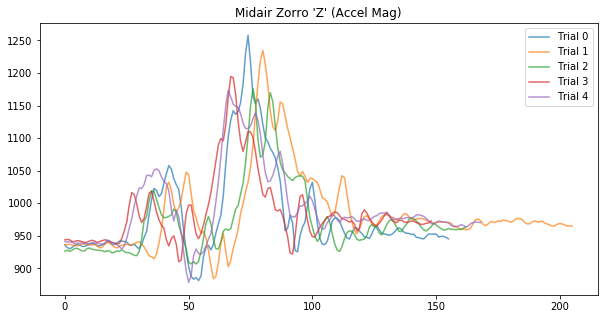

In [6]:
# Now, we need to plot and explore the data. Come up with a shape matching approach 
# and a trained model approach (e.g., decision tree, SVM) to classify the gestures

# For example, here's how you would plot one of the signals
from random import randint
gestureNamesSorted = sorted(mapGestureToTrials.keys())
randomGestureName = gestureNamesSorted[randint(0, len(gestureNamesSorted) - 1)]

# This is where we actually make the plot.
# subplots allows us to make a nice grid of plots. For example, if you want to
# make a 2,2 grid of plots, change the 1 below to 2,2
fig, axes = plt.subplots(1, figsize=(10, 5)) #figsize is width, height
gestureTrials = mapGestureToTrials[randomGestureName]
trialNum = 0
for trial in gestureTrials:
    axes.plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
    trialNum = trialNum + 1

# set the title and show the legend
axes.set_title(randomGestureName + " (Accel Mag)")
axes.legend()


In [7]:

def graphRandomSignals(gestureDictionary, jon, processed=False):
    # Now let's plot all of the accel signals! :)

    # We are going to make a grid of line graphs with a row for each gesture, so len(mapGestureToTrials) rows
    # and a column for each signal type, so 4 columns (one for x, y, z, and mag)
   
    fig, axes = plt.subplots(len(gestureDictionary), 4, figsize=(20, 3 * len(gestureDictionary)))
    fig.subplots_adjust(hspace=0.5)
    titleStr = "";
    if jon:
        titleStr += "jon's raw signals";
    else:
        titleStr +="my raw signals";
        
    if processed:
        titleStr += "(processed)"
        

    index = 0
    gestureNamesSorted = sorted(gestureDictionary.keys())
    for gestureName in gestureNamesSorted:
        gestureTrials = gestureDictionary[gestureName]

        trialNum = 1
        for trial in gestureTrials:
            axes[index][0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trialNum))
            axes[index][1].plot(trial.accel.y, alpha=0.7, label="Trial {}".format(trialNum))
            axes[index][2].plot(trial.accel.z, alpha=0.7, label="Trial {}".format(trialNum))
            axes[index][3].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
            trialNum = trialNum + 1

        axes[index][0].set_title(gestureName + " (Accel X)")
        axes[index][0].legend()

        axes[index][1].set_title(gestureName + " (Accel Y)")
        axes[index][1].legend()

        axes[index][2].set_title(gestureName + " (Accel Z)")
        axes[index][2].legend()

        axes[index][3].set_title(gestureName + " (Accel Mag)")
        axes[index][3].legend()
        index = index + 1
    fig.suptitle(titleStr)


In [18]:
def graphRandomSignalsPadded(gestureDictionary, jon, processed=False):
    # Now let's plot all of the accel signals! :)

    # We are going to make a grid of line graphs with a row for each gesture, so len(mapGestureToTrials) rows
    # and a column for each signal type, so 4 columns (one for x, y, z, and mag)
   
    fig, axes = plt.subplots(len(gestureDictionary), 4, figsize=(20, 3 * len(gestureDictionary)))
    fig.subplots_adjust(hspace=0.5)
    titleStr = "";
    if jon:
        titleStr += "jon's padded signals";
    else:
        titleStr +="my padded signals";
        
    if processed:
        titleStr += "(processed)"
        

    index = 0
    gestureNamesSorted = sorted(gestureDictionary.keys())
    for gestureName in gestureNamesSorted:
        gestureTrials = gestureDictionary[gestureName]

        trialNum = 1
        for trial in gestureTrials:
            axes[index][0].plot(trial.accel.x_padded, alpha=0.7, label="Trial {}".format(trialNum))
            axes[index][1].plot(trial.accel.y_padded, alpha=0.7, label="Trial {}".format(trialNum))
            axes[index][2].plot(trial.accel.z_padded, alpha=0.7, label="Trial {}".format(trialNum))
            axes[index][3].plot(trial.accel.mag_padded, alpha=0.7, label="Trial {}".format(trialNum))
            trialNum = trialNum + 1

        axes[index][0].set_title(gestureName + " (Accel X)")
        axes[index][0].legend()

        axes[index][1].set_title(gestureName + " (Accel Y)")
        axes[index][1].legend()

        axes[index][2].set_title(gestureName + " (Accel Z)")
        axes[index][2].legend()

        axes[index][3].set_title(gestureName + " (Accel Mag)")
        axes[index][3].legend()
        index = index + 1
    fig.suptitle(titleStr)


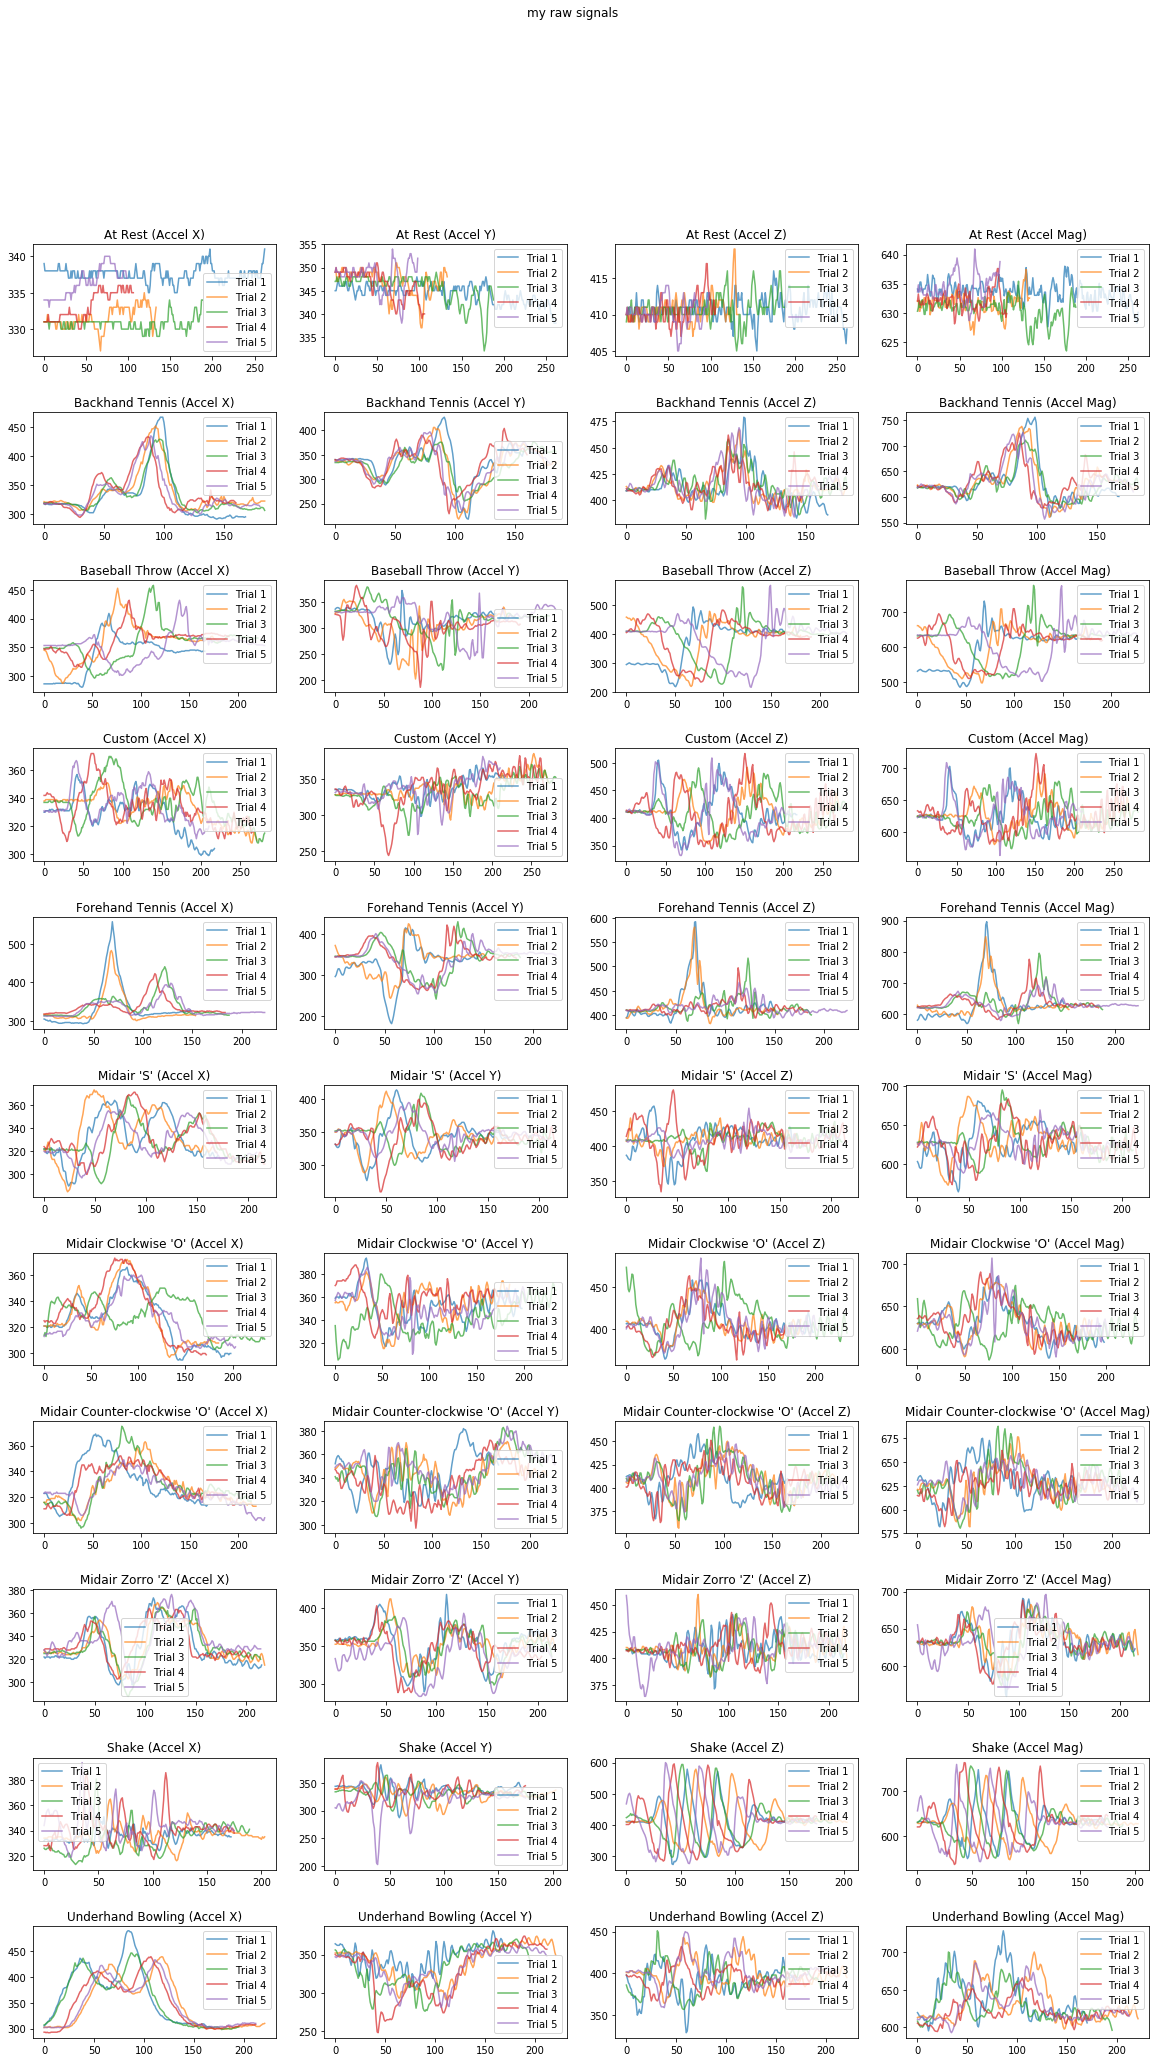

In [8]:
graphRandomSignals(myGesturesToTrials, False)

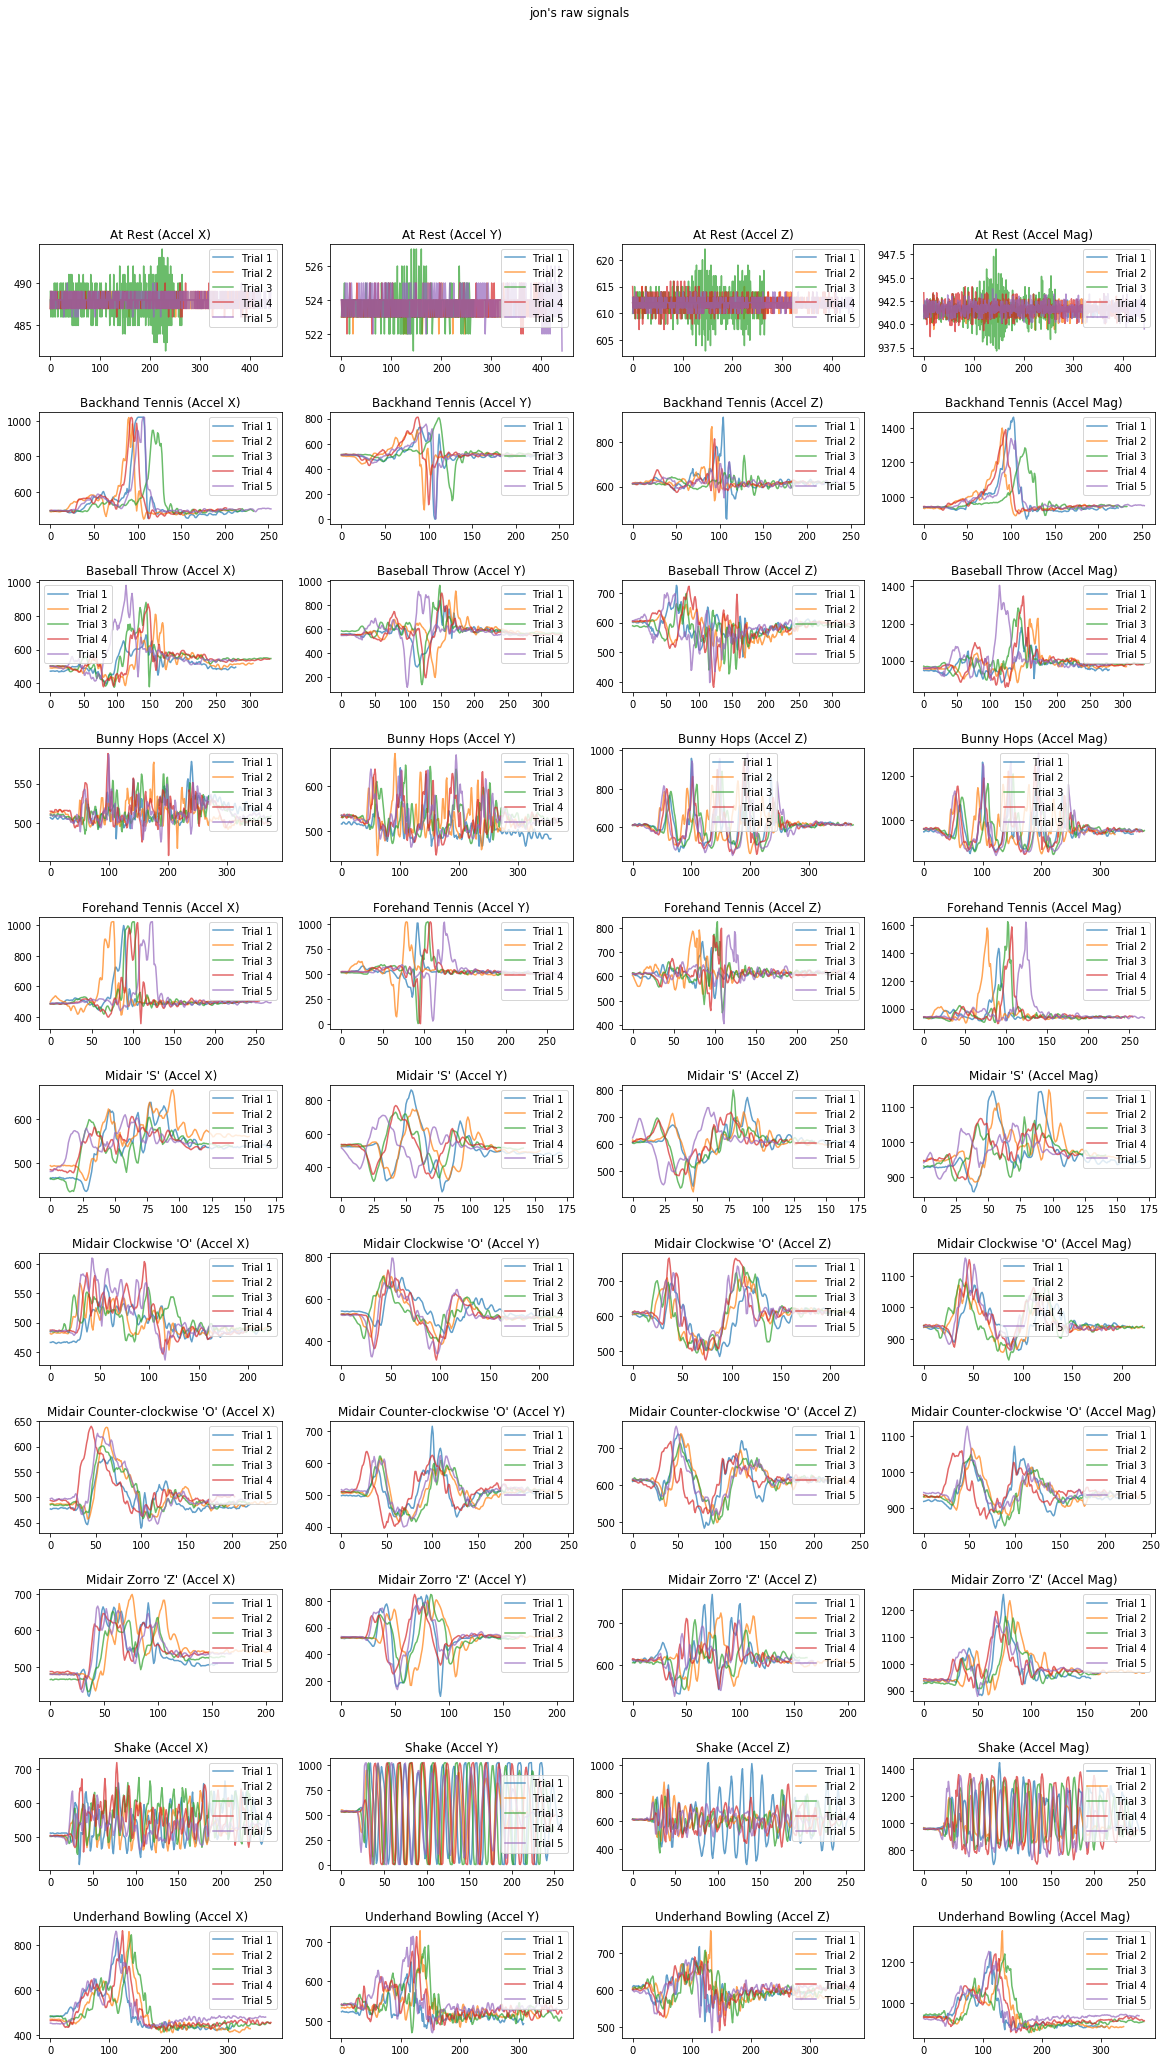

In [9]:
graphRandomSignals(mapGestureToTrials, True)

In [10]:
#function that creates each of the folds (you can then use those later on in comparisons)
from random import randint 

def makeFolds(gestureDictionary, foldNumber):
    foldedDictionary = {};
    
    #build dictionary inside of dictionary.
    for i in range(foldNumber):
        foldedDictionary[i] = {};
    gestureNamesSorted = sorted(gestureDictionary.keys())
    for gesture in gestureNamesSorted:
        gestureList = gestureDictionary[gesture]
        for i in range(0, len(gestureList)):
            gestureNumber = gestureList[i];
            addedToAFold = False;
            while not(addedToAFold):
                index = randint(0, len(gestureList) -1)
                tempGestureDictionary = foldedDictionary[index];
                if gesture not in tempGestureDictionary:
                    addedToAFold = True
                    tempGestureDictionary[gesture] = i;
    return foldedDictionary;

In [11]:
def findLongestSignal(gestureDictionary):
    gestureNamesSorted = sorted(gestureDictionary.keys())
    longest = 0;
    for gesture in gestureNamesSorted:
        gestureList = gestureDictionary[gesture];
        for trial in gestureList: 
            currentSensorData = trial.accel
            sensorDataDictionary = currentSensorData.get_data();
            lengthOfTrial = len(sensorDataDictionary['x'])
            if lengthOfTrial > longest:
                longest = lengthOfTrial
    return longest
                


In [12]:
jonFolds = makeFolds(mapGestureToTrials, 5)
myFolds = makeFolds(myGesturesToTrials, 5)
print(jonFolds)
print(myFolds)

{0: {'At Rest': 1, 'Backhand Tennis': 4, 'Baseball Throw': 3, 'Bunny Hops': 1, 'Forehand Tennis': 2, "Midair 'S'": 0, "Midair Clockwise 'O'": 4, "Midair Counter-clockwise 'O'": 2, "Midair Zorro 'Z'": 0, 'Shake': 2, 'Underhand Bowling': 2}, 1: {'At Rest': 0, 'Backhand Tennis': 3, 'Baseball Throw': 0, 'Bunny Hops': 0, 'Forehand Tennis': 4, "Midair 'S'": 1, "Midair Clockwise 'O'": 2, "Midair Counter-clockwise 'O'": 1, "Midair Zorro 'Z'": 4, 'Shake': 3, 'Underhand Bowling': 1}, 2: {'At Rest': 4, 'Backhand Tennis': 0, 'Baseball Throw': 2, 'Bunny Hops': 3, 'Forehand Tennis': 0, "Midair 'S'": 4, "Midair Clockwise 'O'": 3, "Midair Counter-clockwise 'O'": 0, "Midair Zorro 'Z'": 1, 'Shake': 1, 'Underhand Bowling': 4}, 3: {'At Rest': 3, 'Backhand Tennis': 2, 'Baseball Throw': 1, 'Bunny Hops': 4, 'Forehand Tennis': 3, "Midair 'S'": 3, "Midair Clockwise 'O'": 0, "Midair Counter-clockwise 'O'": 4, "Midair Zorro 'Z'": 3, 'Shake': 4, 'Underhand Bowling': 0}, 4: {'At Rest': 2, 'Backhand Tennis': 1, 'Ba

In [13]:
amountToPadJon = findLongestSignal(mapGestureToTrials)
amountToPadMe = findLongestSignal(myGesturesToTrials)
print(amountToPadJon)

443


In [14]:
import copy
def experimentWithData(gestureDictionary):
    otherDict = copy.deepcopy(gestureDictionary)
    longestLength = findLongestSignal(gestureDictionary)
    print(longestLength)
    gestureNamesSorted = sorted(gestureDictionary.keys());
    for gesture in gestureNamesSorted:
        gestureList = otherDict[gesture]
        for trial in gestureList:
            trial.accel.pad_with_mean(longestLength); #padding with the mean  
    return otherDict      

282


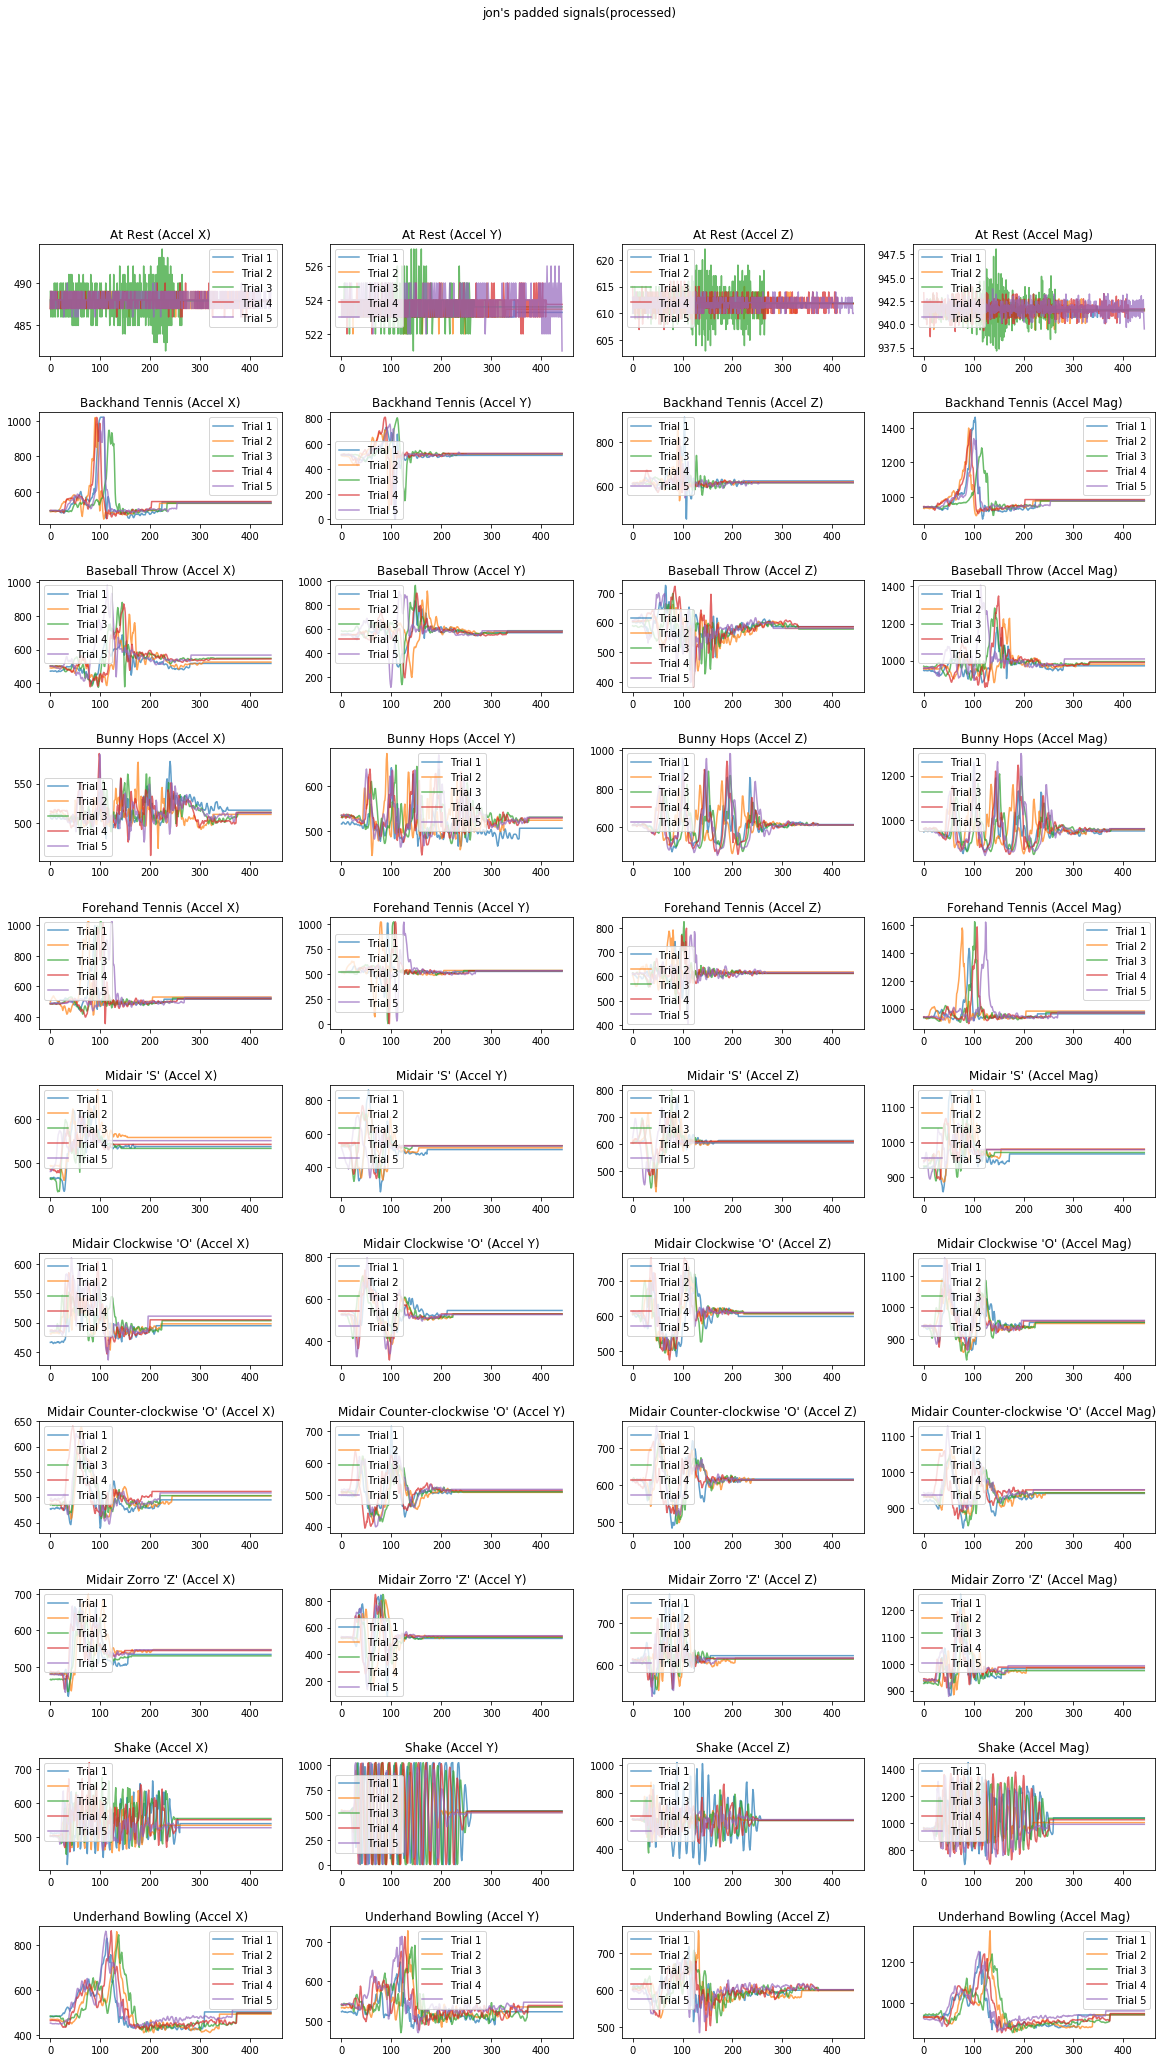

In [20]:
myProcessedData = experimentWithData(myGesturesToTrials);
graphRandomSignalsPadded(jonProcessedData, True, True)


443


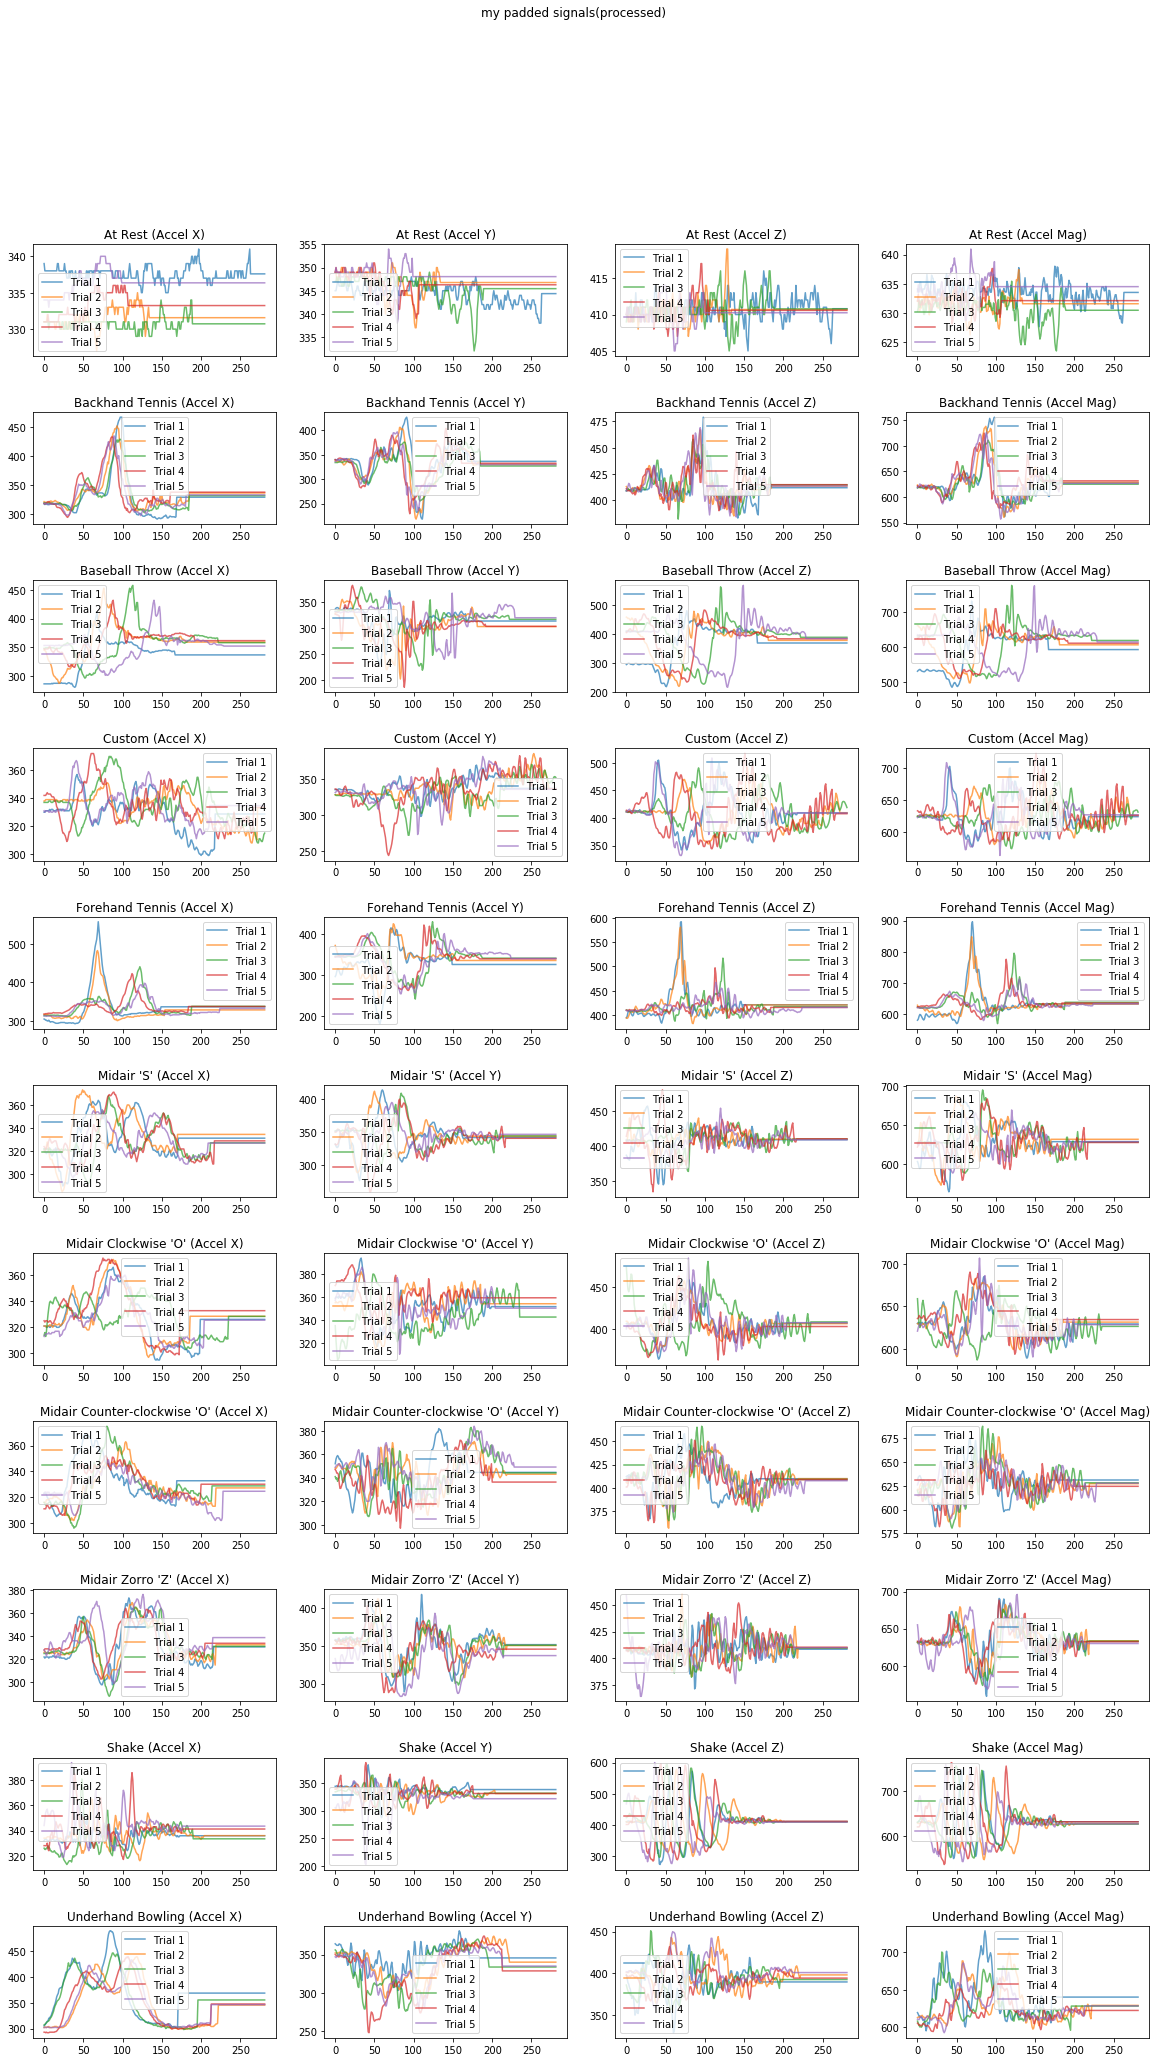

In [19]:
jonProcessedData = experimentWithData(mapGestureToTrials);
graphRandomSignalsPadded(myProcessedData, False, True)

In [17]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

'''
This is jon's function.
'''
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [53]:
from sklearn.metrics import confusion_matrix

#takes in the list of gesture names, the number correct in a trial, the total gesture, the total correct per gesture, 
#predicted gesture results and the actual gesture results and prints out the accuracy, the accuracy per gesture, and the 
#confusion matrix. 
def printResults(gestureNamesSorted, numberCorrect, totalGestures, correctPerGesture, predictedGestureResults, actualGestureResults):
    accuracyRate = numberCorrect/totalGestures;
    print("Percent Out of Total Correct: " + str(accuracyRate))
    for gesture in gestureNamesSorted:
        numberCorrect = correctPerGesture[gesture]
        percentCorrect = numberCorrect / 5;
        print("Percent correct for " + gesture + ": " + str(percentCorrect))
    confmatrix = confusion_matrix(actualGestureResults, predictedGestureResults, gestureNamesSorted)
    plot_confusion_matrix(confmatrix, classes=gestureNamesSorted,
                      title='Confusion matrix (without normalization)')

    plt.figure(figsize=(16,12))

In [54]:
from scipy import signal
from scipy.spatial import distance

# Takes in the processed gesture dictionary and the dictionary that determines what is in each fold and completes fold matching
#in a leave one out way (go through each one and use as a test set).
#also prints accuracy, accuracy per gesture, and the confusion matrix. 
#(i) overall accuracy; (ii) per-gesture accuracy; (iii) and a confusion matrix.
def trainAndRun(processedGestureDictionary, foldDictionary):
    #which dictionary to leave out first.
    gestureNamesSorted = sorted(processedGestureDictionary.keys())
    labels=gestureNamesSorted
    numberCorrect = 0; 
    totalGestures = 55;
    correctPerGesture = {};
    predictedGestureResults = [];
    actualGestureResults = [];
    for i in foldDictionary.keys(): #for each of folds need to do leave one out 
        currentTestSet = foldDictionary[i];
        for gestureName in gestureNamesSorted: #go through all gesture types
            gestureList = processedGestureDictionary[gestureName] #get current list of trials in gesture.
            testGesture = gestureList[currentTestSet[gestureName]] #get test gesture
            testGestureSignal = testGesture.accel; #get signal out of test gesture
            bestGestureMatch = None;
            bestGestureName = "";
            smallestDistance = None;
            for gestureToCompare in gestureNamesSorted: #go compare this to every other trial
                gestureListCompare = processedGestureDictionary[gestureToCompare]; 
                for i in range(len(gestureListCompare)): #go through every gesture of type that is not the one we are leaving out.
                    if i != currentTestSet[gestureToCompare]: # can compare to this. 
                        currentToCompare = gestureListCompare[i];
                        currentSignalToCompare = currentToCompare.accel;
                        euclidDistance = distance.euclidean(currentSignalToCompare.x_padded, testGestureSignal.x_padded)
                        euclidDistance += distance.euclidean(currentSignalToCompare.y_padded, testGestureSignal.y_padded)
                        euclidDistance += distance.euclidean(currentSignalToCompare.z_padded, testGestureSignal.z_padded)
                        if smallestDistance is None or euclidDistance < smallestDistance:
                            smallestDistance = euclidDistance;
                            bestGestureMatch = currentToCompare;
                            bestGestureName = gestureToCompare;
            predictedGesture = bestGestureName;
            if bestGestureName == gestureName: #correct
                numberCorrect += 1
                if predictedGesture in correctPerGesture:
                    correctPerGesture[gestureName] += 1;
                else:
                    correctPerGesture[gestureName] = 1;
            predictedGestureResults.append(predictedGesture)
            actualGestureResults.append(gestureName);  
    printResults(gestureNamesSorted, numberCorrect, totalGestures, correctPerGesture, predictedGestureResults, actualGestureResults)
    

Percent Out of Total Correct: 0.7818181818181819
Percent correct for At Rest: 1.0
Percent correct for Backhand Tennis: 0.8
Percent correct for Baseball Throw: 0.8
Percent correct for Bunny Hops: 0.6
Percent correct for Forehand Tennis: 0.4
Percent correct for Midair 'S': 0.8
Percent correct for Midair Clockwise 'O': 1.0
Percent correct for Midair Counter-clockwise 'O': 1.0
Percent correct for Midair Zorro 'Z': 0.8
Percent correct for Shake: 0.4
Percent correct for Underhand Bowling: 1.0
Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0 0]
 [1 4 0 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0 1]
 [2 0 0 3 0 0 0 0 0 0 0]
 [1 0 0 0 2 0 0 0 1 0 1]
 [0 0 0 0 0 4 0 0 1 0 0]
 [0 0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 1 0 0 4 0 0]
 [0 0 0 0 0 2 0 1 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 5]]


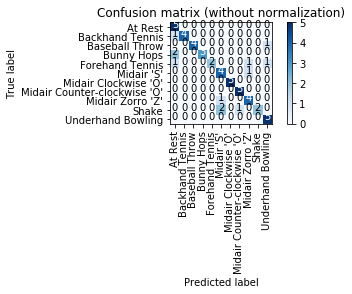

<Figure size 1152x864 with 0 Axes>

In [55]:
trainAndRun(jonProcessedData,jonFolds)

Percent Out of Total Correct: 0.8
Percent correct for At Rest: 1.0
Percent correct for Backhand Tennis: 1.0
Percent correct for Baseball Throw: 0.6
Percent correct for Custom: 0.8
Percent correct for Forehand Tennis: 1.0
Percent correct for Midair 'S': 0.4
Percent correct for Midair Clockwise 'O': 0.8
Percent correct for Midair Counter-clockwise 'O': 1.0
Percent correct for Midair Zorro 'Z': 1.0
Percent correct for Shake: 0.2
Percent correct for Underhand Bowling: 1.0
Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0]
 [0 0 3 2 0 0 0 0 0 0 0]
 [1 0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0]
 [3 0 0 0 0 2 0 0 0 0 0]
 [1 0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0]
 [4 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 5]]


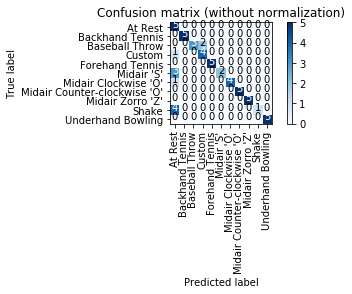

<Figure size 1152x864 with 0 Axes>

In [56]:
trainAndRun(myProcessedData, myFolds)

In [59]:
import numpy as np 
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

#included correlate and shift x and y
def trainAndRunEditCorrelate(processedGestureDictionary, foldDictionary):
    #which dictionary to leave out first.
    gestureNamesSorted = sorted(processedGestureDictionary.keys())
    labels=gestureNamesSorted
    numberCorrect = 0; 
    totalGestures = 55;
    correctPerGesture = {};
    predictedGestureResults = [];
    actualGestureResults = [];
    '''
    corr_result_ab = signal.correlate(a,b)
    best_correlation_point = np.argmax(corr_result_ab)
    index_shift = len(a) - np.argmax(corr_result_ab)
    a_shifted = np.roll(a, index_shift)
    '''
    for i in foldDictionary.keys(): #for each of folds need to do leave one out 
        currentTestSet = foldDictionary[i];
        for gestureName in gestureNamesSorted: #go through all gesture types
            gestureList = processedGestureDictionary[gestureName] #get current list of trials in gesture.
            testGesture = gestureList[currentTestSet[gestureName]] #get test gesture
            testGestureSignal = testGesture.accel; #get signal out of test gesture
            testGestureSignalDstack = np.transpose(np.array([testGestureSignal.x_padded, testGestureSignal.y_padded, testGestureSignal.z_padded]))
            bestGestureMatch = None;
            bestGestureName = "";
            smallestDistance = None;
            for gestureToCompare in gestureNamesSorted: #go compare this to every other trial
                gestureListCompare = processedGestureDictionary[gestureToCompare]; 
                for i in range(len(gestureListCompare)): #go through every gesture of type that is not the one we are leaving out.
                    if i != currentTestSet[gestureToCompare]: # can compare to this. 
                        currentToCompare = gestureListCompare[i];
                        currentSignalToCompare = currentToCompare.accel;
                        currentSignalDstack = np.transpose(np.array([currentSignalToCompare.x_padded, currentSignalToCompare.y_padded, currentSignalToCompare.z_padded]))
                        corr_result_x = signal.correlate(currentSignalToCompare.x_padded, testGestureSignal.x_padded);
                        best_correlation_point = np.argmax(corr_result_x);
                        index_shift = len(currentSignalToCompare.x_padded) - np.argmax(corr_result_x)
                        x_shifted = np.roll(currentSignalToCompare.x_padded, index_shift)
                        y_shifted = np.roll(currentSignalToCompare.y_padded, index_shift)
                        z_shifted = np.roll(currentSignalToCompare.z_padded, index_shift)
                        mag_shifted = np.roll(currentSignalToCompare.mag_padded, index_shift)
                        euclidDistance = distance.euclidean(x_shifted, testGestureSignal.x_padded)
                        euclidDistance += distance.euclidean(y_shifted, testGestureSignal.y_padded)
                        euclidDistance += distance.euclidean(z_shifted, testGestureSignal.z_padded)
                        euclidDistance += distance.euclidean(mag_shifted, testGestureSignal.mag_padded)
                        if smallestDistance is None or euclidDistance < smallestDistance:
                            smallestDistance = euclidDistance;
                            bestGestureMatch = currentToCompare;
                            bestGestureName = gestureToCompare;
            predictedGesture = bestGestureName;
            if bestGestureName == gestureName: #correct
                numberCorrect += 1
                if predictedGesture in correctPerGesture:
                    correctPerGesture[gestureName] += 1;
                else:
                    correctPerGesture[gestureName] = 1;
            predictedGestureResults.append(predictedGesture)
            actualGestureResults.append(gestureName);  
    printResults(gestureNamesSorted, numberCorrect, totalGestures, correctPerGesture, predictedGestureResults, actualGestureResults)
    

In [57]:
import numpy as np 
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

#included fastdtw transformation in this function. rest is similar to before to determine which match the best. 
def trainAndRunEdit(processedGestureDictionary, foldDictionary):
    #which dictionary to leave out first.
    gestureNamesSorted = sorted(processedGestureDictionary.keys())
    labels=gestureNamesSorted
    numberCorrect = 0; 
    totalGestures = 55;
    correctPerGesture = {};
    predictedGestureResults = [];
    actualGestureResults = [];
    '''
    corr_result_ab = signal.correlate(a,b)
    best_correlation_point = np.argmax(corr_result_ab)
    index_shift = len(a) - np.argmax(corr_result_ab)
    a_shifted = np.roll(a, index_shift)
    '''
    for i in foldDictionary.keys(): #for each of folds need to do leave one out 
        currentTestSet = foldDictionary[i];
        for gestureName in gestureNamesSorted: #go through all gesture types
            gestureList = processedGestureDictionary[gestureName] #get current list of trials in gesture.
            testGesture = gestureList[currentTestSet[gestureName]] #get test gesture
            testGestureSignal = testGesture.accel; #get signal out of test gesture
            testGestureSignalDstack = np.transpose(np.array([testGestureSignal.x_padded, testGestureSignal.y_padded, testGestureSignal.z_padded]))
            bestGestureMatch = None;
            bestGestureName = "";
            smallestDistance = None;
            for gestureToCompare in gestureNamesSorted: #go compare this to every other trial
                gestureListCompare = processedGestureDictionary[gestureToCompare]; 
                for i in range(len(gestureListCompare)): #go through every gesture of type that is not the one we are leaving out.
                    if i != currentTestSet[gestureToCompare]: # can compare to this. 
                        currentToCompare = gestureListCompare[i];
                        currentSignalToCompare = currentToCompare.accel;
                        currentSignalDstack = np.transpose(np.array([currentSignalToCompare.x_padded, currentSignalToCompare.y_padded, currentSignalToCompare.z_padded]))
                        euclidDistance = fastdtw(testGestureSignalDstack, currentSignalDstack, dist=euclidean)
                        '''
                        corr_result_x = signal.correlate(currentSignalToCompare.x_padded, testGestureSignal.x_padded);
                        best_correlation_point = np.argmax(corr_result_x);
                        index_shift = len(currentSignalToCompare.x_padded) - np.argmax(corr_result_x)
                        x_shifted = np.roll(currentSignalToCompare.x_padded, index_shift)
                        y_shifted = np.roll(currentSignalToCompare.y_padded, index_shift)
                        z_shifted = np.roll(currentSignalToCompare.z_padded, index_shift)
                        mag_shifted = np.roll(currentSignalToCompare.mag_padded, index_shift)
                        euclidDistance = distance.euclidean(x_shifted, testGestureSignal.x_padded)
                        euclidDistance += distance.euclidean(y_shifted, testGestureSignal.y_padded)
                        euclidDistance += distance.euclidean(z_shifted, testGestureSignal.z_padded)
                        euclidDistance += distance.euclidean(mag_shifted, testGestureSignal.mag_padded)
                        '''
                        if smallestDistance is None or euclidDistance < smallestDistance:
                            smallestDistance = euclidDistance;
                            bestGestureMatch = currentToCompare;
                            bestGestureName = gestureToCompare;
            predictedGesture = bestGestureName;
            if bestGestureName == gestureName: #correct
                numberCorrect += 1
                if predictedGesture in correctPerGesture:
                    correctPerGesture[gestureName] += 1;
                else:
                    correctPerGesture[gestureName] = 1;
            predictedGestureResults.append(predictedGesture)
            actualGestureResults.append(gestureName);  
    printResults(gestureNamesSorted, numberCorrect, totalGestures, correctPerGesture, predictedGestureResults, actualGestureResults)
    

C:\Users\nicol\Anaconda3tryagain\lib\site-packages\scipy\signal\signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


Percent Out of Total Correct: 0.7818181818181819
Percent correct for At Rest: 1.0
Percent correct for Backhand Tennis: 0.8
Percent correct for Baseball Throw: 0.8
Percent correct for Bunny Hops: 0.8
Percent correct for Forehand Tennis: 0.4
Percent correct for Midair 'S': 0.8
Percent correct for Midair Clockwise 'O': 1.0
Percent correct for Midair Counter-clockwise 'O': 0.8
Percent correct for Midair Zorro 'Z': 1.0
Percent correct for Shake: 0.2
Percent correct for Underhand Bowling: 1.0
Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0 1]
 [0 0 4 0 1 0 0 0 0 0 0]
 [1 0 0 4 0 0 0 0 0 0 0]
 [1 0 0 0 2 0 0 0 1 0 1]
 [0 0 0 0 0 4 0 0 1 0 0]
 [0 0 0 0 0 0 5 0 0 0 0]
 [1 0 0 0 0 0 0 4 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 3 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 5]]


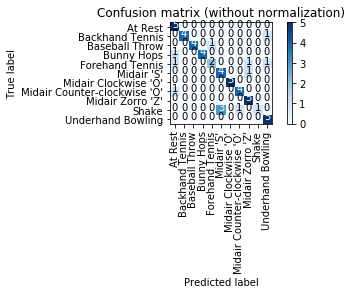

<Figure size 1152x864 with 0 Axes>

In [60]:
trainAndRunEditCorrelate(jonProcessedData, jonFolds)

Percent Out of Total Correct: 0.7818181818181819
Percent correct for At Rest: 1.0
Percent correct for Backhand Tennis: 1.0
Percent correct for Baseball Throw: 0.6
Percent correct for Custom: 0.6
Percent correct for Forehand Tennis: 0.8
Percent correct for Midair 'S': 0.4
Percent correct for Midair Clockwise 'O': 0.8
Percent correct for Midair Counter-clockwise 'O': 0.8
Percent correct for Midair Zorro 'Z': 1.0
Percent correct for Shake: 0.6
Percent correct for Underhand Bowling: 1.0
Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0]
 [0 0 3 1 1 0 0 0 0 0 0]
 [2 0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 4 0 0 0 1 0 0]
 [3 0 0 0 0 2 0 0 0 0 0]
 [1 0 0 0 0 0 4 0 0 0 0]
 [1 0 0 0 0 0 0 4 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0]
 [2 0 0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 0 0 5]]


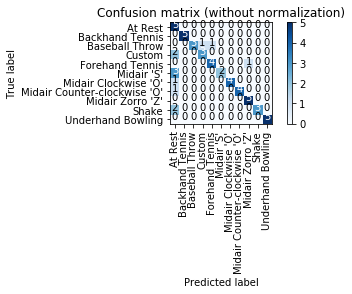

<Figure size 1152x864 with 0 Axes>

In [61]:
trainAndRunEditCorrelate(myProcessedData, myFolds)

In [ ]:
trainAndRunEdit(jonProcessedData,jonFolds)

In [ ]:
trainAndRunEdit(myProcessedData, myFolds)

In [ ]:
# Start analyzing and comparing these gesture signals.
# Think about:
#  - What patterns do you see in the data?
#  - What kind of filtering might be useful?
#  - How can you best align the signals for comparison? (e.g., hint: scroll down to see the Euclidean distance comparisons)
#  - What kind of signal transforms might be useful? (e.g., ffts, derivative waveforms)
#  - What is the simplest way we can compare two signals?
#  - What classes might you want to create to help you keep things organized? (e.g., your k-fold experiments and results)
#  - For k-fold cross validation, check out: http://scikit-learn.org/stable/modules/cross_validation.html or implement your own
